In [1]:
!pip install langchain -q

In [6]:
import re, json, os, langchain

class Message:
    def __init__(self, type, content, additional_kwargs={}, example=False):
        self.type = type
        self.content = content
        self.additional_kwargs = additional_kwargs
        self.example = example

def parse_messages(raw_data):
    messages = []
    # Pattern to match message strings
    pattern = re.compile(r"(\w+Message)\(content=['\"](.*?)['\"], additional_kwargs=({.*?})(, example=(\w+))?\)", re.DOTALL)
    for match in pattern.findall(raw_data):
        message_type, content, additional_kwargs, _, example = match
        # Convert strings of additional_kwargs and example to their actual types
        additional_kwargs = eval(additional_kwargs)
        example = eval(example) if example else False
        message = Message(message_type, content, additional_kwargs, example)
        messages.append(message)
    return messages

# Test the script
base_dir = "./full_autogpt_log/"
log_files = [
    "alfworld_autogpt_result_log_gpt35_il_r2.txt",
    "alfworld_autogpt_result_log_claude_il_2.txt",
    "alfworld_autogpt_result_log_gpt4_il.txt",
]

# Print parsed messages
#for message in messages:
#    print(f"Type: {message.type}\nContent: {message.content}\nAdditional Kwargs: {message.additional_kwargs}\nExample: {message.example}\n---")


In [7]:
def extract_command(text):
# Define the pattern
    pattern = r"\['(.*?)'\]"

    # Use findall to find all matches
    matches = re.findall(pattern, text)

    # Print matches
    res = []
    for match in matches:
        parameter = match
        # command = command.lower()
        command = 'alfworld_action'
        parameter = parameter.lower()
        #print(f"Command: {command}\nParameter: {parameter}\n---")
        res.append(f"{command}:{parameter}")
    return res


In [10]:
from output_parser import preprocess_json_input
def check_agree_rate(messages, f_name):
    disagree, agree = 0, 0
    for i, m in enumerate(messages):
        if m.type == "HumanMessage":
            res = extract_command(m.content)
            if res:
                try:
                    res_set = set(res)
                    assert messages[i+1].type == "AIMessage"
                    s = bytes(messages[i+1].content, 'utf-8').decode('unicode_escape')
                    #print(s)
                    ai_r = json.loads(preprocess_json_input(s), strict=False)
                    if ai_r["command"]["name"] in ("alfworld_action") and ai_r["command"]["args"].get("tool_input"):                    
                    # if ai_r["command"]["name"] in ("search", "click"):
                        ai_r_txt = ai_r["command"]["name"].lower() + ":" + \
                                   ai_r["command"]["args"]["tool_input"].lower()
                        if ai_r_txt in res_set:
                            agree +=1 
                        else:
                            disagree += 1
                except json.JSONDecodeError:
                    pass
                    # print(s)
    total = disagree + agree +0.0
    print(f_name, agree/total, disagree/total)

In [11]:
for i in range(0, len(log_files)):
    f = log_files[i]
    log_file = base_dir + f
    with open(log_file, "r") as file:
        log_text = file.read()

    messages = parse_messages(log_text)
    check_agree_rate(messages, f)


alfworld_autogpt_result_log_gpt35_il_r2.txt 0.1857397504456328 0.8142602495543672
alfworld_autogpt_result_log_claude_il_2.txt 0.23126177024482109 0.7687382297551789
alfworld_autogpt_result_log_gpt4_il.txt 0.145679012345679 0.854320987654321


['alfworld_autogpt_result_log_gpt35_il_r2.txt 0.1857397504456328 0.8142602495543672\n', 'alfworld_autogpt_result_log_claude_il_2.txt 0.23126177024482109 0.7687382297551789\n', 'alfworld_autogpt_result_log_gpt4_il.txt 0.145679012345679 0.854320987654321\n']
[[0.1857397504456328, 0.8142602495543672], [0.23126177024482109, 0.7687382297551789], [0.145679012345679, 0.854320987654321]]


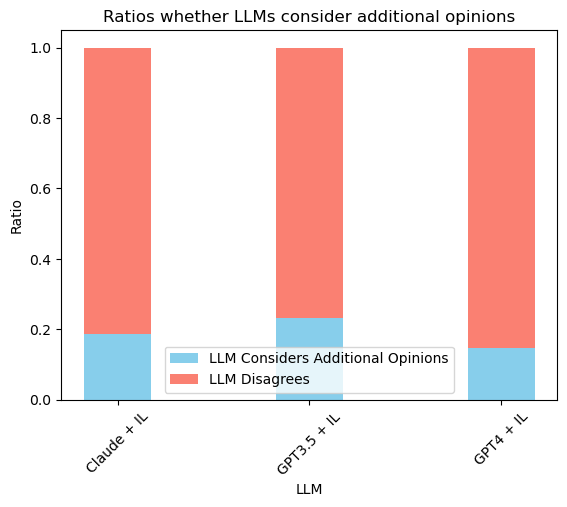

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import io

# Assuming the data is in a string
data_string = """alfworld_autogpt_result_log_gpt35_il_r2.txt 0.1857397504456328 0.8142602495543672
alfworld_autogpt_result_log_claude_il_2.txt 0.23126177024482109 0.7687382297551789
alfworld_autogpt_result_log_gpt4_il.txt 0.145679012345679 0.854320987654321
"""

# Convert the string to a file-like object
f = io.StringIO(data_string)

# Read the lines from the file-like object
lines = f.readlines()
print(lines)

# Split the lines into labels and data
labels = ["Claude + IL", "GPT3.5 + IL", "GPT4 + IL"]
data = [list(map(float, line.split()[1:])) for line in lines]
print(data)
# Convert data to numpy array for easier manipulation
data = np.array(data)

# Create an index for each group of bars
bar_index = np.arange(len(labels))

# Define bar width
bar_width = 0.35

# Create the bars
fig, ax = plt.subplots()
bar1 = ax.bar(bar_index, data[:, 0], bar_width, label='LLM Considers Additional Opinions', color='skyblue')
bar2 = ax.bar(bar_index, data[:, 1], bar_width, bottom=data[:, 0], label='LLM Disagrees', color='salmon')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('LLM')
ax.set_ylabel('Ratio')
ax.set_title('Ratios whether LLMs consider additional opinions')
ax.set_xticks(bar_index)
ax.set_xticklabels(labels)
ax.legend()

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.show()
